In [1]:
%load_ext autoreload
%autoreload 2

!date
!whoami

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Sun Jun 23 16:48:45 PDT 2019
ndbs


# Start testing the projection function on real data

In [2]:
import find_closest_route_point as f

## Open data file for route 7 with closest shape points already found

In [5]:
!ls ../data/transformed/

route_7_DowntownSeattleViaRainierAveS_shape_10007006_node_trips_w_nearest_2018-08-15_2018-12-11.csv


In [6]:
df = pd.read_csv('../data/transformed/route_7_DowntownSeattleViaRainierAveS_shape_10007006_node_trips_w_nearest_2018-08-15_2018-12-11.csv',
                index_col='index')
df.head()

,route_id,timestamp,trip_id,vehicle_id,vehicle_lat,vehicle_long,time_utc,time_pct,day,year,...,stop_name,stop_lat,stop_lon,trip_headsign,route_short_name,route_desc,trip_start_time,actual_time_from_scheduled_start,scheduled_time_from_scheduled_start,distance_btw_veh_and_shape
index,,,,,,,,,,,,,,,,,,,,,
0,100263,1535759730,39478305,4534,47.523304,-122.268219,2018-08-31 23:55:30,2018-08-31 16:55:30-07:00,31,2018,...,S Henderson St & Rainier Ave S,47.523235,-122.268219,Downtown Seattle Via Rainier Ave S,7.0,Prentice St - Rainier Beach - Downtown Seattle,2019-06-16 17:03:00,-7.500000,0.000000,0.001661
1,100263,1535759926,39478060,4520,47.529758,-122.269997,2018-08-31 23:58:46,2018-08-31 16:58:46-07:00,31,2018,...,Rainier Ave S & S Rose St,47.529728,-122.269897,Downtown Seattle Via Rainier Ave S,7.0,Prentice St - Rainier Beach - Downtown Seattle,2019-06-16 16:52:00,6.766667,7.000000,4.665079
2,100263,1535759927,39478068,4521,47.575783,-122.296181,2018-08-31 23:58:47,2018-08-31 16:58:47-07:00,31,2018,...,Rainier Ave S & S Mount Baker Blvd,47.575809,-122.296089,Downtown Seattle Via Rainier Ave S,7.0,Prentice St - Rainier Beach - Downtown Seattle,2019-06-16 16:33:00,25.783333,23.083333,1.031650
4,100263,1535759941,39478293,4531,47.549232,-122.277054,2018-08-31 23:59:01,2018-08-31 16:59:01-07:00,31,2018,...,Rainier Ave S & S Kenny St,47.549225,-122.276947,Downtown Seattle Via Rainier Ave S,7.0,Prentice St - Rainier Beach - Downtown Seattle,2019-06-16 16:42:00,17.016667,11.950000,1.782479
5,100263,1535759958,39478267,4536,47.581169,-122.300301,2018-08-31 23:59:18,2018-08-31 16:59:18-07:00,31,2018,...,Rainier Ave S & S Bayview St,47.581196,-122.300201,Downtown Seattle Via Rainier Ave S,7.0,Prentice St - Rainier Beach - Downtown Seattle,2019-06-16 16:27:00,32.300000,25.683333,1.392724


In [7]:
df.loc[0]

route_id                                                                       100263
timestamp                                                                  1535759730
trip_id                                                                      39478305
vehicle_id                                                                       4534
vehicle_lat                                                                   47.5233
vehicle_long                                                                 -122.268
time_utc                                                          2018-08-31 23:55:30
time_pct                                                    2018-08-31 16:55:30-07:00
day                                                                                31
year                                                                             2018
month                                                                               8
hour                                                  

## Sort values to compare points on the same trip

In [8]:
df.sort_values(['month_day_trip_veh', 'shape_pt_sequence']).iloc[1]

route_id                                                                       100263
timestamp                                                                  1539218695
trip_id                                                                      40984830
vehicle_id                                                                       4527
vehicle_lat                                                                   47.5216
vehicle_long                                                                 -122.264
time_utc                                                          2018-10-11 00:44:55
time_pct                                                    2018-10-10 17:44:55-07:00
day                                                                                10
year                                                                             2018
month                                                                              10
hour                                                  

In [9]:
df.sort_values(['month_day_trip_veh', 'shape_pt_sequence']).iloc[2]

route_id                                                  100263
timestamp                                             1539218662
trip_id                                                 40984830
vehicle_id                                                  4527
vehicle_lat                                              47.5198
vehicle_long                                            -122.266
time_utc                                     2018-10-11 00:44:22
time_pct                               2018-10-10 17:44:22-07:00
day                                                           10
year                                                        2018
month                                                         10
hour                                                          17
dow                                                            2
direction_id                                                   1
shape_id                                                10007006
month_day_trip_veh       

## Load shapes data

In [11]:
!ls ../data/source/gtfs_20180815

agency.txt          calendar.txt        fare_rules.txt      stop_times.txt
block.txt           calendar_dates.txt  routes.txt          stops.txt
block_trip.txt      fare_attributes.txt shapes.txt          trips.txt


In [12]:
shapes_df = pd.read_csv('../data/source/gtfs_20180815/shapes.txt')

In [109]:
shapes_df.tail()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
373890,41982011,47.673229,-122.101021,607,131283.5
373891,41982011,47.673279,-122.100990,608,131302.5
373892,41982011,47.673351,-122.100990,609,131328.0
373893,41982011,47.673569,-122.101059,610,131409.5
373894,41982011,47.673599,-122.101059,611,131419.0


## Write a wrapper function to find the closest route point for each row

NOTE: It is quite slow to `.apply` this function to the 182618 rows of location data in this particular file. I didn't time it, so I'm not sure how slow, but I think it was more than 10 minutes.

I think it will be worth trying to "vectorize" the functions in `find_closest_route_point.py`, i.e. rewrite them to take a dataframe as input and operate directly on entire columns rather than on single numbers, thus avoiding the need to use `.apply`. I think this should result in passing off the main outer `for` loop to `numpy`/`C`, which should result in a speedup; I'm curious to see how much difference that makes.

In [13]:
def transform_row(row):
    """Get the closest route point and shape distance for a row"""
    return f.find_closest_point_on_route(shapes_df, row.shape_id, row.vehicle_lat, row.vehicle_long, row.shape_pt_sequence)

In [85]:
# WARNING: This takes several minutes to run (~15 minutes(?) on my computer)
closest_points = df.apply(transform_row, axis=1)

In [86]:
closest_points

index
0         ([-122.26821899414062, 47.523303999999996], 0....
1         ([-122.269997, 47.52975845336914], 7477.713018...
2         ([-122.29617218849184, 47.57578366628681], 260...
4         ([-122.27705710073377, 47.54923102303739], 149...
5         ([-122.30028775154207, 47.58116824502017], 282...
6         ([-122.27036028610475, 47.5373810851632], 1026...
7         ([-122.2974777367926, 47.57748015924321], 2676...
8         ([-122.32840728759766, 47.5992012], 39215.9065...
9         ([-122.27979964741714, 47.55344953702593], 167...
11        ([-122.27297981600384, 47.54268934375549], 123...
12        ([-122.3002918366536, 47.58115995091032], 2827...
13        ([-122.33017166405241, 47.60167346550371], 403...
14        ([-122.2855827448728, 47.55887972055843], 1923...
15        ([-122.30238995344557, 47.583901182373985], 29...
16        ([-122.2660140991211, 47.5232964], 547.7636440...
18        ([-122.27781859050252, 47.55145464650786], 158...
20        ([-122.28721779147902, 4

In [87]:
closest_points[0]

(array([-122.26821899,   47.523304  ]), 0.001459632370744325)

In [89]:
closest_points[0][0][0]

-122.26821899414062

In [90]:
closest_points[:][0]

(array([-122.26821899,   47.523304  ]), 0.001459632370744325)

## Fail!! Time to debug...

I had some of the array shapes wrong. Namely:

1. The direction vector needed to be transposed in the `get_projection_and_dist_ratio` function to handle the case when it was actually a matrix containing two direction vectors;
2. I needed to use `dist_ratio.reshape(-1)` rather than `dist_ratio.reshape(2)` in the `find_closest_point_on_route` function since sometimes `dist_ratio` contains only one number instead of 2.

In [73]:
row = df.loc[0]
row

route_id                                                                       100263
timestamp                                                                  1535759730
trip_id                                                                      39478305
vehicle_id                                                                       4534
vehicle_lat                                                                   47.5233
vehicle_long                                                                 -122.268
time_utc                                                          2018-08-31 23:55:30
time_pct                                                    2018-08-31 16:55:30-07:00
day                                                                                31
year                                                                             2018
month                                                                               8
hour                                                  

In [74]:
print(row.shape_id, row.vehicle_lat, row.vehicle_long, row.shape_pt_sequence)

10007006 47.5233039855957 -122.26821899414062 1


In [75]:
shape_pt_data = f.get_shape_point_data(shapes_df, row.shape_id, row.shape_pt_sequence)
shape_pt_data

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
3964,10007006,47.523304,-122.268219,1,0.0


In [76]:
adjacent_shape_pt_data = f.get_adjacent_shape_point_data(shapes_df, shape_pt_data.index[0])
adjacent_shape_pt_data

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
3965,10007006,47.523304,-122.267319,2,224.2


In [77]:
vehicle_pt = np.array([row.vehicle_long, row.vehicle_lat])
closest_shape_pt = shape_pt_data[['shape_pt_lon', 'shape_pt_lat']].values
adjacent_pts = adjacent_shape_pt_data[['shape_pt_lon', 'shape_pt_lat']].values
print(vehicle_pt, closest_shape_pt, adjacent_pts)

[-122.26821899   47.52330399] [[-122.268219   47.523304]] [[-122.267319   47.523304]]


In [83]:
closest_pt, dist_ratio = f.get_projection_and_dist_ratio(vehicle_pt, closest_shape_pt, adjacent_pts)
print(closest_pt, dist_ratio)

[-122.26821899   47.52330399] [[-122.268219   47.523304]] [[0.0009 0.    ]]
[[-122.26821899   47.523304  ]] [[6.51040308e-06]]


In [79]:
#np.array([[-122.267319, 47.523304]]) - np.array([[-122.268219, 47.523304]])
direction = adjacent_pts - closest_shape_pt
direction

array([[0.0009, 0.    ]])

In [80]:
#np.array([-122.26821899, 47.52330399]) - np.array([[-122.268219, 47.523304]])
vehicle_pt - closest_shape_pt

array([[ 5.85936277e-09, -1.44042929e-08]])

In [81]:
(vehicle_pt - closest_shape_pt).dot(direction.T)

array([[5.2734265e-12]])

In [82]:
direction.T

array([[0.0009],
       [0.    ]])

## Add the closest route points and distances to the dataframe

In [97]:
closest_points

index
0         ([-122.26821899414062, 47.523303999999996], 0....
1         ([-122.269997, 47.52975845336914], 7477.713018...
2         ([-122.29617218849184, 47.57578366628681], 260...
4         ([-122.27705710073377, 47.54923102303739], 149...
5         ([-122.30028775154207, 47.58116824502017], 282...
6         ([-122.27036028610475, 47.5373810851632], 1026...
7         ([-122.2974777367926, 47.57748015924321], 2676...
8         ([-122.32840728759766, 47.5992012], 39215.9065...
9         ([-122.27979964741714, 47.55344953702593], 167...
11        ([-122.27297981600384, 47.54268934375549], 123...
12        ([-122.3002918366536, 47.58115995091032], 2827...
13        ([-122.33017166405241, 47.60167346550371], 403...
14        ([-122.2855827448728, 47.55887972055843], 1923...
15        ([-122.30238995344557, 47.583901182373985], 29...
16        ([-122.2660140991211, 47.5232964], 547.7636440...
18        ([-122.27781859050252, 47.55145464650786], 158...
20        ([-122.28721779147902, 4

In [99]:
closest_points.apply(lambda x: x[0][1])

index
0         47.523304
1         47.529758
2         47.575784
4         47.549231
5         47.581168
6         47.537381
7         47.577480
8         47.599201
9         47.553450
11        47.542689
12        47.581160
13        47.601673
14        47.558880
15        47.583901
16        47.523296
18        47.551455
20        47.561007
22        47.521647
23        47.553451
24        47.583901
25        47.604167
26        47.568510
29        47.519852
30        47.587084
31        47.558880
32        47.607010
34        47.522869
35        47.564503
36        47.590326
38        47.572891
            ...    
239934    47.609631
239935    47.594345
239936    47.570410
239937    47.556336
239938    47.523304
239939    47.607028
239942    47.558901
239943    47.523296
239946    47.596089
239947    47.572868
239948    47.564503
239949    47.521655
239950    47.609623
239951    47.599205
239952    47.575775
239954    47.521328
239957    47.599194
239959    47.523304
239960    47.5

In [100]:
df['route_pt_lat'] = closest_points.apply(lambda x: x[0][1]) #Lattitude is second coordinate

In [102]:
df['route_pt_lon'] = closest_points.apply(lambda x: x[0][0]) #Longitude is first coordinate

In [104]:
df['vehicle_shape_dist_traveled'] = closest_points.apply(lambda x: x[1])

In [105]:
df.head()

,route_id,timestamp,trip_id,vehicle_id,vehicle_lat,vehicle_long,time_utc,time_pct,day,year,...,trip_headsign,route_short_name,route_desc,trip_start_time,actual_time_from_scheduled_start,scheduled_time_from_scheduled_start,distance_btw_veh_and_shape,route_pt_lat,route_pt_lon,vehicle_shape_dist_traveled
index,,,,,,,,,,,,,,,,,,,,,
0,100263,1535759730,39478305,4534,47.523304,-122.268219,2018-08-31 23:55:30,2018-08-31 16:55:30-07:00,31,2018,...,Downtown Seattle Via Rainier Ave S,7.0,Prentice St - Rainier Beach - Downtown Seattle,2019-06-16 17:03:00,-7.500000,0.000000,0.001661,47.523304,-122.268219,0.001460
1,100263,1535759926,39478060,4520,47.529758,-122.269997,2018-08-31 23:58:46,2018-08-31 16:58:46-07:00,31,2018,...,Downtown Seattle Via Rainier Ave S,7.0,Prentice St - Rainier Beach - Downtown Seattle,2019-06-16 16:52:00,6.766667,7.000000,4.665079,47.529758,-122.269997,7477.713019
2,100263,1535759927,39478068,4521,47.575783,-122.296181,2018-08-31 23:58:47,2018-08-31 16:58:47-07:00,31,2018,...,Downtown Seattle Via Rainier Ave S,7.0,Prentice St - Rainier Beach - Downtown Seattle,2019-06-16 16:33:00,25.783333,23.083333,1.031650,47.575784,-122.296172,26068.810971
4,100263,1535759941,39478293,4531,47.549232,-122.277054,2018-08-31 23:59:01,2018-08-31 16:59:01-07:00,31,2018,...,Downtown Seattle Via Rainier Ave S,7.0,Prentice St - Rainier Beach - Downtown Seattle,2019-06-16 16:42:00,17.016667,11.950000,1.782479,47.549231,-122.277057,14982.225282
5,100263,1535759958,39478267,4536,47.581169,-122.300301,2018-08-31 23:59:18,2018-08-31 16:59:18-07:00,31,2018,...,Downtown Seattle Via Rainier Ave S,7.0,Prentice St - Rainier Beach - Downtown Seattle,2019-06-16 16:27:00,32.300000,25.683333,1.392724,47.581168,-122.300288,28281.797898


## Save the new data!

In [111]:
df.reset_index().to_csv('../data/transformed/route_7_DowntownSeattleViaRainierAveS_shape_10007006_node_trips_w_route_distances_2018-08-15_2018-12-11.csv')

In [112]:
!ls ../data/transformed/

route_7_DowntownSeattleViaRainierAveS_shape_10007006_node_trips_w_nearest_2018-08-15_2018-12-11.csv
route_7_DowntownSeattleViaRainierAveS_shape_10007006_node_trips_w_route_distances_2018-08-15_2018-12-11.csv


## Compare our computed closest route points to vehicle location and closest shape point

* The vehicle lattitde and longitude should be very close to closest route point lattitude and longitude, perhaps equal.
* The `shape_dist_traveled` to the nearest shape point should be close to the `vehicle_shape_dist_traveled` to the nearest route point, but not equal.

In [106]:
df.columns

Index(['route_id', 'timestamp', 'trip_id', 'vehicle_id', 'vehicle_lat',
       'vehicle_long', 'time_utc', 'time_pct', 'day', 'year', 'month', 'hour',
       'dow', 'direction_id', 'shape_id', 'month_day_trip_veh',
       'shape_pt_sequence', 'shape_dist_traveled', 'shape_pt_lat',
       'shape_pt_lon', 'arrival_time', 'departure_time', 'stop_id',
       'stop_sequence', 'stop_name', 'stop_lat', 'stop_lon', 'trip_headsign',
       'route_short_name', 'route_desc', 'trip_start_time',
       'actual_time_from_scheduled_start',
       'scheduled_time_from_scheduled_start', 'distance_btw_veh_and_shape',
       'route_pt_lat', 'route_pt_lon', 'vehicle_shape_dist_traveled'],
      dtype='object')

In [107]:
# Compare actual vehicle lattitde and longitude to closest route point lattitude and longitude,
# and compare shape distance to nearest shape point so shape distance to the closest route point (i.e. the vehicle)
df[['vehicle_lat','vehicle_long', 'shape_dist_traveled', 'route_pt_lat', 'route_pt_lon', 'vehicle_shape_dist_traveled']]

,vehicle_lat,vehicle_long,shape_dist_traveled,route_pt_lat,route_pt_lon,vehicle_shape_dist_traveled
index,,,,,,
0,47.523304,-122.268219,0.0,47.523304,-122.268219,0.001460
1,47.529758,-122.269997,7462.6,47.529758,-122.269997,7477.713019
2,47.575783,-122.296181,26065.4,47.575784,-122.296172,26068.810971
4,47.549232,-122.277054,14977.2,47.549231,-122.277057,14982.225282
5,47.581169,-122.300301,28277.6,47.581168,-122.300288,28281.797898
6,47.537380,-122.270370,10257.2,47.537381,-122.270360,10263.145270
7,47.577477,-122.297485,26765.1,47.577480,-122.297478,26766.612389
8,47.599197,-122.328407,39210.2,47.599201,-122.328407,39215.906598
9,47.553471,-122.279800,16723.8,47.553450,-122.279800,16736.335349


In [117]:
(df[['vehicle_lat','vehicle_long', 'shape_dist_traveled']].values
 -df[['route_pt_lat', 'route_pt_lon', 'vehicle_shape_dist_traveled']].values)

array([[-1.44042929e-08,  0.00000000e+00, -1.45963237e-03],
       [ 0.00000000e+00,  3.56933597e-07, -1.51130188e+01],
       [-8.90407911e-07, -8.53660582e-06, -3.41097106e+00],
       ...,
       [ 1.54811312e-06, -1.13209640e-06, -8.96071566e-01],
       [-7.91593280e-08, -2.06814676e-07, -4.69890324e-02],
       [ 0.00000000e+00,  3.56933597e-07,  6.94892752e+01]])

### Ugh, we need the column names to be identical in order to subtract the dataframes and use `.describe()`

In [118]:
colnames = pd.DataFrame({'original': ['vehicle_lat','vehicle_long', 'shape_dist_traveled'],
                         'new': ['route_pt_lat', 'route_pt_lon', 'vehicle_shape_dist_traveled'],
                         'shared': ['delta_lat', 'delta_lon', 'delta_dist']
                        })
colnames

,original,new,shared
0,vehicle_lat,route_pt_lat,delta_lat
1,vehicle_long,route_pt_lon,delta_lon
2,shape_dist_traveled,vehicle_shape_dist_traveled,delta_dist


In [119]:
colnames.set_index('original')['shared']

original
vehicle_lat             delta_lat
vehicle_long            delta_lon
shape_dist_traveled    delta_dist
Name: shared, dtype: object

In [121]:
df[colnames['original']].head()

,vehicle_lat,vehicle_long,shape_dist_traveled
index,,,
0,47.523304,-122.268219,0.0
1,47.529758,-122.269997,7462.6
2,47.575783,-122.296181,26065.4
4,47.549232,-122.277054,14977.2
5,47.581169,-122.300301,28277.6


In [125]:
(df[colnames['new']].rename(columns=colnames.set_index('new')['shared'])
 - df[colnames['original']].rename(columns=colnames.set_index('original')['shared'])
).head()

,delta_lat,delta_lon,delta_dist
index,,,
0,1.440429e-08,0.000000e+00,0.001460
1,0.000000e+00,-3.569336e-07,15.113019
2,8.904079e-07,8.536606e-06,3.410971
4,-1.459873e-06,-3.267726e-06,5.025282
5,-8.833978e-07,1.284660e-05,4.197898


In [126]:
(df[colnames['new']].rename(columns=colnames.set_index('new')['shared'])
 - df[colnames['original']].rename(columns=colnames.set_index('original')['shared'])
).describe()

,delta_lat,delta_lon,delta_dist
count,1.826180e+05,1.826180e+05,182618.000000
mean,3.594777e-06,-2.220382e-06,-2.356046
std,1.082053e-04,8.167448e-05,53.050700
min,-5.120801e-03,-6.451549e-03,-3230.902467
25%,-3.678352e-06,-1.092979e-06,-1.210039
50%,0.000000e+00,1.591367e-08,1.512389
75%,8.904079e-07,7.010657e-06,5.945270
max,1.224518e-02,1.579490e-02,798.381781


## Woo hoo! Looks pretty good. Except there are some outlier distances...

In [127]:
delta_df = (df[colnames['new']].rename(columns=colnames.set_index('new')['shared'])
            - df[colnames['original']].rename(columns=colnames.set_index('original')['shared'])
           )

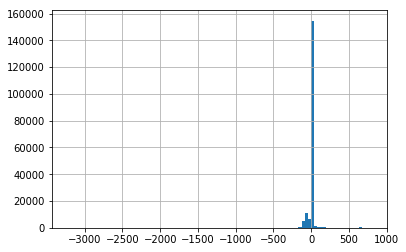

In [128]:
delta_df['delta_dist'].hist(bins=100)

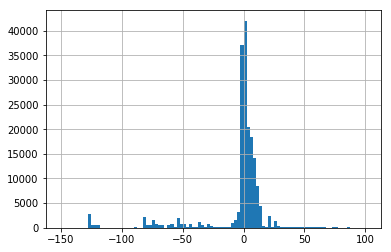

In [133]:
delta_df.loc[(delta_df['delta_dist']>-150) & (delta_df['delta_dist']< 100), 'delta_dist'].hist(bins=100)

### How many distances are outside the above cutoff window [-150m, 100m]?

Looks like 2437, or 1.33% of the total 182,618 rows.

These distances are the difference between the shape distance to the closest shape point, and shape distances to the projection of the vehicle onto the route. Large differences suggest that the vehicle is not actually on the route. In fact, we should be able to use trigonometry to tell exactly when these differences are larger than expected based on distances between consecutive shape points... 

In [134]:
delta_df.loc[(delta_df['delta_dist']<-150) | (delta_df['delta_dist']>100), 'delta_dist'].shape

(2437,)

In [135]:
2437 / 182618

0.01334479624133437

## Let's check out some histograms and scatter plots for the lattitude and longitude

The outliers for lattitude or longitude should correspond to the outliers for the distances. What do the scatter plots tell us?

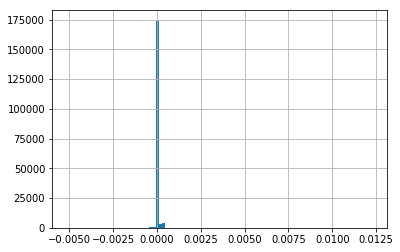

In [138]:
delta_df['delta_lat'].hist(bins=100)

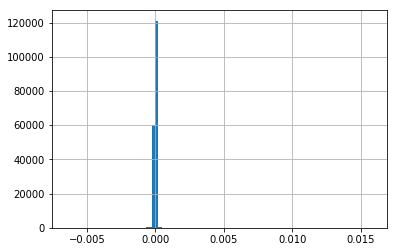

In [139]:
delta_df['delta_lon'].hist(bins=100)

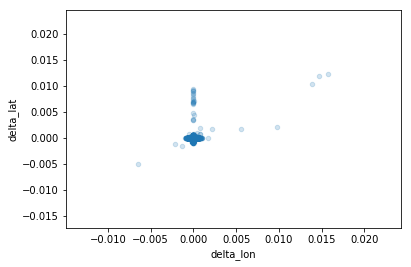

In [147]:
delta_df.plot(x='delta_lon', y='delta_lat', kind='scatter', alpha=0.2) # Hmm, that's interesting...

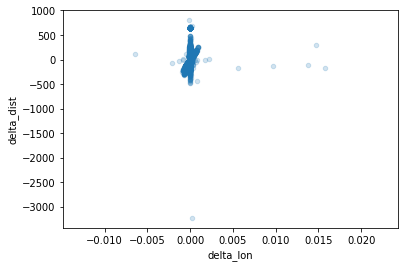

In [146]:
delta_df.plot(x='delta_lon', y='delta_dist', kind='scatter', alpha=0.2)

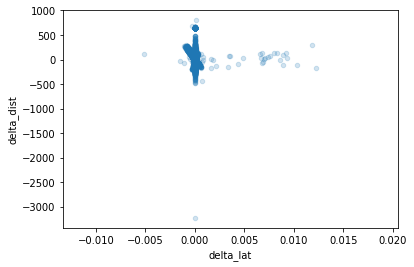

In [148]:
delta_df.plot(x='delta_lat', y='delta_dist', kind='scatter', alpha=0.2)